In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow import keras 
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

%matplotlib inline

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"
%cd /content/gdrive/My Drive/Kaggle/Dogs vs Cats

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/Kaggle/Dogs vs Cats


In [0]:
# Download kaggle dataset
!kaggle competitions download -c dogs-vs-cats
!unzip -qq \*.zip
%rm *.zip

In [0]:
# Only will work with 1000 samples by class and 400 aditional samples from each class as validation data 
%mkdir -p data/train/dogs data/train/cats data/validation/dogs data/validation/cats
os.system("find train -name 'dog.*' | head -1400 | xargs -I filename mv filename data/train/dogs")
os.system("find train -name 'cat.*' | head -1400 | xargs -I filename mv filename data/train/cats")

0

In [0]:
%cd /content/gdrive/My Drive/Kaggle/Dogs vs Cats/data/train/dogs
os.system('ls | tail -400 | xargs -I filename mv filename ../../validation/dogs')
%cd /content/gdrive/My Drive/Kaggle/Dogs vs Cats/data/train/cats
os.system('ls | tail -400 | xargs -I filename mv filename ../../validation/cats')
%cd /content/gdrive/My Drive/Kaggle/Dogs vs Cats

/content/gdrive/My Drive/Kaggle/Dogs vs Cats/data/train/dogs
/content/gdrive/My Drive/Kaggle/Dogs vs Cats/data/train/cats
/content/gdrive/My Drive/Kaggle/Dogs vs Cats


In [0]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K

# dimensions of our images.
img_width, img_height = 150, 150

train_data_dir = 'data/train'
validation_data_dir = 'data/validation'
nb_train_samples = 2000
nb_validation_samples = 800
epochs = 30
batch_size = 16

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

In [0]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [0]:
# train augmentation
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [0]:
# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        'data/train',  # this is the target directory
        target_size=(150, 150),  # all images will be resized to 150x150
        batch_size=batch_size,
        class_mode='binary')  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        'data/validation',
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')

In [0]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size)

Epoch 1/50
125/125 [==============================] - 21s 168ms/step - loss: 0.6163 - accuracy: 0.6625 - val_loss: 0.6605 - val_accuracy: 0.7038
Epoch 2/50
125/125 [==============================] - 20s 158ms/step - loss: 0.6051 - accuracy: 0.6890 - val_loss: 0.5229 - val_accuracy: 0.7275
Epoch 3/50
125/125 [==============================] - 19s 155ms/step - loss: 0.5728 - accuracy: 0.7185 - val_loss: 0.4275 - val_accuracy: 0.7000
Epoch 4/50
125/125 [==============================] - 19s 156ms/step - loss: 0.5662 - accuracy: 0.7205 - val_loss: 0.6937 - val_accuracy: 0.7337
Epoch 5/50
125/125 [==============================] - 20s 160ms/step - loss: 0.5374 - accuracy: 0.7410 - val_loss: 0.6418 - val_accuracy: 0.7225
Epoch 6/50
125/125 [==============================] - 19s 153ms/step - loss: 0.5383 - accuracy: 0.7320 - val_loss: 0.7282 - val_accuracy: 0.6787
Epoch 7/50
125/125 [==============================] - 19s 155ms/step - loss: 0.5282 - accuracy: 0.7390 - val_loss: 0.6977 - val_ac

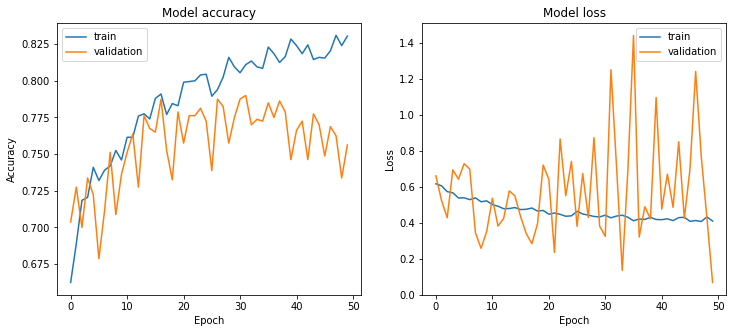

In [0]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.legend(['train', 'validation'], loc='best')
ax1.set(xlabel='Epoch', ylabel='Accuracy')
ax1.set_title('Model accuracy');

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.legend(['train', 'validation'], loc='best')
ax2.set(xlabel='Epoch', ylabel='Loss')
ax2.set_title('Model loss');